### Quem sou eu

Sou uma pessoa com 29 anos que gosta de usar a ciência e os dados para resolver problemas do dia a dia. Tenho conhecimento em análise estatística de dados, visualização interativa, automação e web scrapping, criação, otimização e avaliação de modelos de machine learning, e utilização de bibliotecas para Ciência de Dados. Também publiquei projetos no GitHub, incluindo análise do impacto de feriados nas vendas, análise estatística/exploratória em dados de E-commerce, e análise e decomposição de séries temporais nas vendas.

Veja meu portifólio: https://portfolio.powerbiexperience.com/p/ueliton

### Quais dados são estes?

O Walmart é uma conhecida corporação de varejo que opera uma cadeia de hipermercados. Neste contexto, a Walmart forneceu dados combinando 45 lojas, incluindo informações sobre a loja e vendas mensais. Os dados são fornecidos semanalmente. A Walmart tenta encontrar o impacto das férias nas vendas da loja. Para isso, incluiu quatro semanas de férias no conjunto de dados, que são o Natal, o Dia de Ação de Graças, o Super Bowl e o Dia do Trabalho. Aqui, estamos em posição de analisar o conjunto de dados fornecido. Antes de fazer isso, gostaria de destacar o objetivo desta análise.

Nosso objetivo principal é prever as vendas da loja em uma semana. Como no conjunto de dados são dados tamanho e tempo como características, analisamos se as vendas são impactadas por fatores baseados no tempo e no espaço. Mais importante ainda, como a inclusão de feriados em uma semana aumenta as vendas na loja? Para isso, realizaremos uma análise exploratória para entendimento do problema, seguida de uma análise explanatória para estudar os insights e prever as vendas com um modelo de machine learning.

### Dicionário dos dados

|Coluna|Do que se trata|
|:--------|:--------|
|Store| Lojas da rede (45 unidades)|
|Date| Data em que a foto foi tirada|
|Weekly_Sales| Total das Vendas Semanais para uma determinada loja|
|IsHoliday| Teve feriado especial nesta semana?|
|Temperature| Temperatura média da região|
|Fuel_Price| Preço em dólar do combustível na região|
|CPI| Índice de preços ao consumidor da região da loja|
|Unemployment| Taxa de desemprego na região|
|Super_Bowl| Feriado de Super_Bowl|
|Labor_Day| Feriado do Dia do Trabalho|
|Thanksgiving| Feriado de Ação de graças|
|Christmas| Feriado de Natal|
|week| semana do ano|
|month| mês em que a foto foi tirada|
|year| ano em que a foto foi tirada|
|Type| tem A,B e C|
|Size| Tamanho da loja|
|Dept| Departamento da loja|
|MarkDown1| Descontos promocionais da loja|
|MarkDown2| Descontos promocionais da loja|
|MarkDown3| Descontos promocionais da loja|
|MarkDown4| Descontos promocionais da loja|
|MarkDown5| Descontos promocionais da loja|

---

### Importando as bibliotecas

In [1]:
import os
import numpy as np
import pandas as pd
import scipy.stats as stats
from statsmodels.stats.diagnostic import het_breuschpagan
import statsmodels as sm

from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import lightgbm as lgb

import matplotlib.pyplot as plt  
import plotly.express as px
import seaborn as sns
%matplotlib inline    

import warnings
warnings.filterwarnings("ignore")

### Criando a classe das funções que foram comumente utilizadas

In [2]:
class ProcessadorDados:
    def __init__(self):
        pass
    
    
    # função recebe o caminho de um arquivo e retorna um dataframe do pacote pandas com os dados contidos no arquivo.
    def importar_dados(self, caminho_arquivo,index_col=None,parse_dates=None):
        df = pd.read_csv(caminho_arquivo,index_col=index_col, parse_dates=parse_dates)
        return df
    
    
    # Função de correlação em gráfico triangular
    def correlacao(self, data, show_high=False):
        corr = data.corr() # Gerando a tabela de correlação
        # Criando um filtro para mostrar apenas correlações significativas
        if show_high == True:
            corr = corr[((corr >= .5) | (corr <= -.5)) & (corr != 1)]
        # Criando uma matriz de valores booleanos, onde os dados só aparecerão, caso o valor seja False
        mask = np.zeros_like(corr, dtype=bool)
        mask[np.triu_indices_from(mask)] = True

        fig, aux = plt.subplots(figsize=(11,11))

        # Gerando a paleta de cores
        cmap = sns.diverging_palette(240, 10, as_cmap=True)

        sns.heatmap(
            corr,          
            mask=mask,     # mascara triangular de True/False
            vmin=-1, 
            vmax=1, 
            cmap="RdBu",     # paleta de cores
            annot=True,    # plotar os valores dentro das células
            square=True,   # Forçar células a serem quadradas
            linewidths=.5, # Largura das linhas que dividem as células
            cbar_kws={"shrink": .5})
        fig.show()
    
    
    # Define a importância das variáveis para um desfecho
    def importancia(self, data=pd.DataFrame(), nomes_colunas_x=[], nome_y=[], shuffle=True, test_size=0.3,titulo_grafico='Título Padrão', random_state=0, xgb_n_estimators=100):
        # Definindo variáveis dependentes e independentes
        X = data[nomes_colunas_x]
        y = data[nome_y]

        # Separando os dados
        X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=shuffle, test_size=test_size, random_state=random_state)

        # Instanciando e treinando o modelo com os dados de treino
        xgb = XGBRegressor(n_estimators=xgb_n_estimators)
        xgb.fit(X_train, y_train)

        # Calculando a importancia e transformando os dados de retorno
        valores_importancia = xgb.feature_importances_
        feat_imp = pd.DataFrame(valores_importancia).sort_values(by=0,ascending=False).T
        feat_imp.columns = X.columns
        feat_imp = feat_imp.T.reset_index()
        feat_imp.columns = ['Característica','Importância para as vendas']

        # Plotando os resultados
        fig = px.bar(feat_imp,
                     x='Característica',
                     y='Importância para as vendas',
                     title=titulo_grafico, 
                     width=800, 
                     height=400)
        fig.update_layout(xaxis=dict(showgrid=False), 
                           yaxis=dict(showgrid=False))
        return feat_imp, fig
    
    
    def heterocedasticidade(self, y_pred, y_test):
        # calcular o teste de Levene
        levene_test = levene(y_pred, y_test)

        # verificar se o valor-p é menor que 0,05
        if levene_test.pvalue < 0.05:
            print("Heterocedasticidade detectada com p-valor =", levene_test.pvalue)
        else:
            print("Não foi detectada heterocedasticidade com p-valor =", levene_test.pvalue)
    
    
    def plot_dataframe(self, df, chart_type, title, x_label=None, y_label=None, x_column=None, y_column=None, range_y=[0,2000000], width=800, height=400,showlegend=True,color=None):
        # Cria o gráfico de acordo com o tipo especificado
        if chart_type == "bar":
            fig = px.bar(df, x=x_column, y=y_column, title=title, width=width, height=height)
            fig.update_layout(showlegend=showlegend,xaxis=dict(showgrid=False), yaxis=dict(showgrid=False))
        elif chart_type == "line":
            fig = px.line(df, x=x_column, y=y_column, title=title, width=width, height=height,range_y=range_y)
            fig.update_layout(showlegend=showlegend,xaxis=dict(showgrid=False), yaxis=dict(showgrid=False))
        elif chart_type == "boxplot":
            fig = px.box(df, x=x_column, y=y_column, title=title, width=width, height=height,color=color)
            fig.update_layout(showlegend=showlegend,xaxis=dict(showgrid=False), yaxis=dict(showgrid=False))
        elif chart_type == "histogram":
            fig = px.histogram(df, x=x_column, title=title, width=width, height=height)
            fig.update_layout(showlegend=showlegend,xaxis=dict(showgrid=False), yaxis=dict(showgrid=False))
        elif chart_type == "scatter":
            fig = px.scatter(df, x=x_column, y=y_column, title=title, width=width, height=height)
            fig.update_layout(showlegend=showlegend,xaxis=dict(showgrid=False), yaxis=dict(showgrid=False))
        else:
            # Tipo de gráfico inválido
            raise ValueError("Invalid chart type. Valid chart types are: bar, line, boxplot, histogram, scatter")

        # Atualiza os rótulos das coordenadas x e y
        fig.update_layout(xaxis_title=x_label, yaxis_title=y_label)

        # Exibe o gráfico
        fig.show()

# instanciando a classe
processador = ProcessadorDados()

### Carregando os dados)

In [3]:
# Importando os dados, definindo as colunas de índice e data 
df_full = processador.importar_dados('../input/walmart/clean_data (1).csv', index_col='Unnamed: 0',parse_dates=['Date'])
# Adicionando uma nova coluna de temperatura em Grau Celsius
df_full['Temperature_C'] = round((df_full['Temperature']-32)*5/9,2)
# Adicionando uma nova coluna de dia do mês
df_full['day'] = df_full['Date'].dt.day
# Filtrando observações com vendas acima de 10 dólares por semana
df_full = df_full[(df_full['Weekly_Sales'] > 10)]
# Criando uma cópia dos dados para controle
df = df_full.copy()
df.to_csv('teste.csv')

In [4]:
# Visualizando uma amostra aleatória dos dados
df.sample(5)

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,...,Size,Super_Bowl,Labor_Day,Thanksgiving,Christmas,week,month,year,Temperature_C,day
272471,28,81,2011-07-29,18931.02,False,93.29,3.805,0.00,0.0,0.00,...,206302,False,False,False,False,30,7,2011,34.05,29
206019,21,34,2012-07-06,19098.80,False,85.26,3.227,6607.09,63.2,37.39,...,140167,False,False,False,False,27,7,2012,29.59,6
91845,10,28,2011-03-25,1369.28,False,62.53,3.716,0.00,0.0,0.00,...,126512,False,False,False,False,12,3,2011,16.96,25
877,1,8,2010-04-30,34168.23,False,67.41,2.780,0.00,0.0,0.00,...,151315,False,False,False,False,17,4,2010,19.67,30
83940,9,10,2011-09-30,11286.52,False,78.45,3.355,0.00,0.0,0.00,...,125833,False,False,False,False,39,9,2011,25.81,30


---
### **Etapa de Análise Exploratória**

### Visualizando os dados

In [5]:
# Visualizando e convertendo os tipos dos dados
df = df.astype({'Store':'object','Dept':'object'})
display(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 414490 entries, 0 to 421569
Data columns (total 25 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Store          414490 non-null  object        
 1   Dept           414490 non-null  object        
 2   Date           414490 non-null  datetime64[ns]
 3   Weekly_Sales   414490 non-null  float64       
 4   IsHoliday      414490 non-null  bool          
 5   Temperature    414490 non-null  float64       
 6   Fuel_Price     414490 non-null  float64       
 7   MarkDown1      414490 non-null  float64       
 8   MarkDown2      414490 non-null  float64       
 9   MarkDown3      414490 non-null  float64       
 10  MarkDown4      414490 non-null  float64       
 11  MarkDown5      414490 non-null  float64       
 12  CPI            414490 non-null  float64       
 13  Unemployment   414490 non-null  float64       
 14  Type           414490 non-null  object        
 15  

None

In [6]:
# Separando as colunas pelos seus respectivos tipos
cols_quanti = ['Weekly_Sales','Fuel_Price','CPI','Unemployment','Size','Temperature','Temperature_C']
cols_markD = ['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']
cols_date = ['Date','week','month','year','day']
cols_object = ['Store', 'Dept', 'IsHoliday','Type','Super_Bowl','Labor_Day', 'Thanksgiving', 'Christmas']

In [7]:
# Imprimindo as estatísticas
print('\nResumo estatístico das variáveis quantitativas'.upper())
display(df[cols_quanti].describe().T)


RESUMO ESTATÍSTICO DAS VARIÁVEIS QUANTITATIVAS


,count,mean,std,min,25%,50%,75%,max
Weekly_Sales,414490.0,16254.381819,22807.156534,10.020,2284.582500,7872.1550,20540.597500,693099.360000
Fuel_Price,414490.0,3.360753,0.458454,2.472,2.933000,3.4520,3.738000,4.468000
CPI,414490.0,171.232150,39.153362,126.064,132.064433,182.3806,212.464799,227.232807
Unemployment,414490.0,7.955714,1.861838,3.879,6.891000,7.8660,8.567000,14.313000
Size,414490.0,137228.614148,60815.679381,34875.000,93638.000000,140167.0000,202505.000000,219622.000000
Temperature,414490.0,60.033653,18.446193,-2.060,46.660000,62.0300,74.240000,100.140000
Temperature_C,414490.0,15.574251,10.247921,-18.920,8.140000,16.6800,23.470000,37.860000


In [8]:
# Imprimindo as estatísticas
print('\n\nResumo estatístico das variáveis de descontos'.upper())
display(df[cols_markD].describe().T)



RESUMO ESTATÍSTICO DAS VARIÁVEIS DE DESCONTOS


,count,mean,std,min,25%,50%,75%,max
MarkDown1,414490.0,2602.267375,6069.298020,0.00,0.0,0.0,2840.78,88646.76
MarkDown2,414490.0,886.061840,5097.888636,-265.76,0.0,0.0,2.63,104519.54
MarkDown3,414490.0,473.568390,5565.056067,-29.10,0.0,0.0,4.59,141630.61
MarkDown4,414490.0,1089.211391,3910.186558,0.00,0.0,0.0,436.50,67474.85
MarkDown5,414490.0,1668.137820,4206.312071,0.00,0.0,0.0,2194.68,108519.28


In [9]:
# Imprimindo as estatísticas
print('\n\nResumo estatístico das variáveis de data/tempo'.upper())
display(df[cols_date].describe(include='all').T)



RESUMO ESTATÍSTICO DAS VARIÁVEIS DE DATA/TEMPO


,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
Date,414490,143,2011-12-23,2990,2010-02-05,2012-10-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN
week,414490.0,NaN,NaT,NaN,NaT,NaT,25.839166,14.16703,1.0,14.0,26.0,38.0,52.0
month,414490.0,NaN,NaT,NaN,NaT,NaT,6.452291,3.24679,1.0,4.0,6.0,9.0,12.0
year,414490.0,NaN,NaT,NaN,NaT,NaT,2010.968086,0.796689,2010.0,2010.0,2011.0,2012.0,2012.0
day,414490.0,NaN,NaT,NaN,NaT,NaT,15.675324,8.753031,1.0,8.0,16.0,23.0,31.0


In [10]:
print('\n\nResumo estatístico das variáveis qualitativas e booleanas'.upper())
display(df[cols_object].describe().T)



RESUMO ESTATÍSTICO DAS VARIÁVEIS QUALITATIVAS E BOOLEANAS


,count,unique,top,freq
Store,414490,45,13,10379
Dept,414490,80,1,6435
IsHoliday,414490,2,False,385275
Type,414490,3,A,212827
Super_Bowl,414490,2,False,405713
Labor_Day,414490,2,False,405793
Thanksgiving,414490,2,False,408598
Christmas,414490,2,False,408641


In [11]:
print('\nTotal de linhas duplicadas'.upper())
display(df.duplicated().sum())
print('\nTotal de valores faltantes por coluna'.upper())
df.isnull().sum()


TOTAL DE LINHAS DUPLICADAS


0


TOTAL DE VALORES FALTANTES POR COLUNA


Store            0
Dept             0
Date             0
Weekly_Sales     0
IsHoliday        0
Temperature      0
Fuel_Price       0
MarkDown1        0
MarkDown2        0
MarkDown3        0
MarkDown4        0
MarkDown5        0
CPI              0
Unemployment     0
Type             0
Size             0
Super_Bowl       0
Labor_Day        0
Thanksgiving     0
Christmas        0
week             0
month            0
year             0
Temperature_C    0
day              0
dtype: int64

In [12]:
df_feriado = df.loc[df['IsHoliday'] == True]

display('Quais semanas do ano que contém feriados?')
display(df_feriado['week'].unique())

print("""
Os dados analisados possuem 4 feriados distintos, sendo eles:

1º Super Bowl (Fevereiro, 6ª semana do ano)
2º Dia do Trabalho (Setembro, 36ª semana do ano)
3º Ação de graças (Novembro, 47ª semana do ano)
4º Natal (Dezembro, 52ª semana do ano)
""")

'Quais semanas do ano que contém feriados?'

array([ 6, 36, 47, 52])


Os dados analisados possuem 4 feriados distintos, sendo eles:

1º Super Bowl (Fevereiro, 6ª semana do ano)
2º Dia do Trabalho (Setembro, 36ª semana do ano)
3º Ação de graças (Novembro, 47ª semana do ano)
4º Natal (Dezembro, 52ª semana do ano)



In [13]:
# 143 semanas distintas
print(f"{len(df['Date'].unique())} semanas distintas")

# 12 meses distintos
print(f"{len(df['Date'].dt.month.unique())} meses distintos")

# 3 anos distintos
print(f"{len(df['Date'].dt.year.unique())} anos disponíveis (2010, 2011 e 2012)")

# 80 Departamentos de vendas
print(f"{len(df['Dept'].unique())} Departamentos distintos")

143 semanas distintas
12 meses distintos
3 anos disponíveis (2010, 2011 e 2012)
80 Departamentos distintos


---
### Filtrando e Transformando os dados

In [14]:
# (Limitando as datas para obter apenas dois meses de cada ano para futuras comparações)
df_custom = df.loc[(df['Date'] >= '04/01/2010') & (df['Date']<= '03/31/2012')]
# Aplicando transformação nos dados categóricos Type
dummies_type = pd.get_dummies(df_custom['Type'], prefix='Type')
# Transformando dasdos categóricos on-hot
df_custom.Thanksgiving.replace({False:0, True:1},inplace=True)
df_custom.Super_Bowl.replace({False:0, True:1},inplace=True)
df_custom.Type.replace({"A":1,"B":2,"C":3},inplace=True)
df_custom.Christmas.replace({False:0, True:1},inplace=True)
df_custom.IsHoliday.replace({False:0, True:1},inplace=True)
df_custom.Labor_Day.replace({False:0, True:1},inplace=True)
df_custom.drop(['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5','Temperature'],axis=1,inplace=True)

df_custom = pd.concat([df_custom,dummies_type], axis=1)
df_custom.sample(5)

,Store,Dept,Date,Weekly_Sales,IsHoliday,Fuel_Price,CPI,Unemployment,Type,Size,...,Thanksgiving,Christmas,week,month,year,Temperature_C,day,Type_A,Type_B,Type_C
80290,9,56,2010-08-06,845.29,0,2.627,215.064843,6.442,2,125833,...,0,0,31,8,2010,30.61,6,0,1,0
31861,4,38,2010-09-17,85200.58,0,2.594,126.145467,7.372,1,205863,...,0,0,37,9,2010,18.28,17,1,0,0
288485,30,21,2010-11-05,2109.12,0,2.689,211.613505,8.163,3,42988,...,0,0,44,11,2010,14.84,5,0,0,1
416274,45,80,2011-04-29,1001.27,0,3.962,185.802953,8.521,2,118221,...,0,0,17,4,2011,18.99,29,0,1,0
130476,14,95,2010-09-24,149821.35,0,2.713,182.669674,8.743,1,200898,...,0,0,38,9,2010,20.33,24,1,0,0


---
### Visualizando as Correlações e Variáveis Importantes

In [15]:
# Quando olhamos para a proporção de feriados nas semanas, podemos notar que apenas 7% dos dados são de feriados.
propFer = round(df_custom['IsHoliday'].value_counts(normalize=True),4)
print('Proporção de semanas sem feriados[0] e semanas Com feriados[1]:')
propFer*100

Proporção de semanas sem feriados[0] e semanas Com feriados[1]:


0    92.31
1     7.69
Name: IsHoliday, dtype: float64

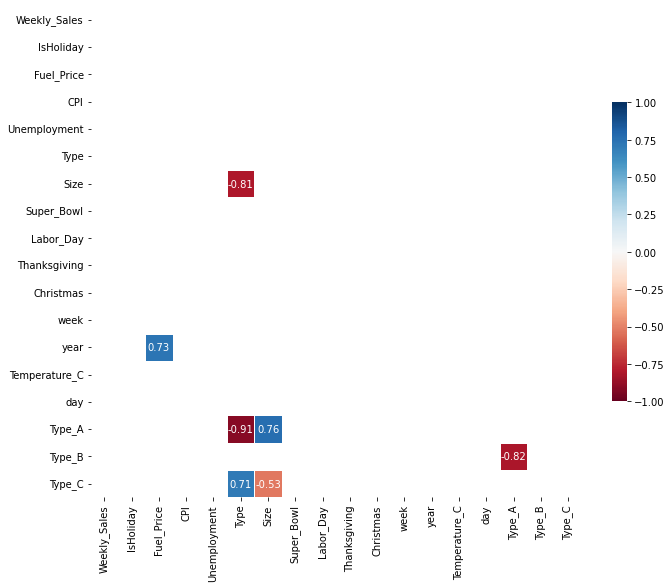

In [16]:
drop_cols = ['month']
# Alterar show_high para False para ver todas as células
processador.correlacao(df_custom.drop(drop_cols,axis=1),show_high=True) # show_high=True, acima de 0.5

In [17]:
# Add 2 semanas antes e depois das semanas de feriado para realcar os impactos e diminuir a diferenca de 93%/7%. Ex: 6(±2), 36(±2), 47(±2), 52(±2)
semanas_permitidas = [4,5,6,7,8,34,35,36,37,38,45,46,47,48,49,50,51,52,53,54]
df_small = df_custom.loc[df_custom['week'].isin(semanas_permitidas)].drop(drop_cols,axis=1)
propFerSmall = round(df_small['IsHoliday'].value_counts(normalize=True)*100,2)
print('A diferença de proporção foi aumentada significativamente')
propFerSmall

A diferença de proporção foi aumentada significativamente


0    77.73
1    22.27
Name: IsHoliday, dtype: float64

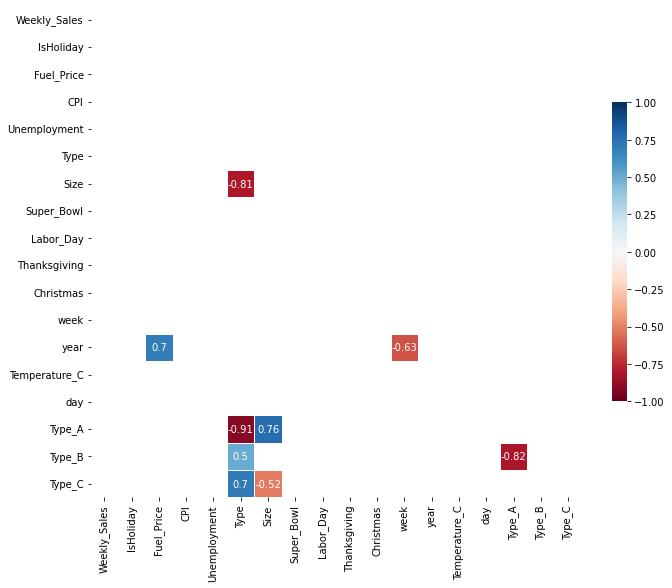

In [18]:
# Dessa vez com as semanas perto de feriados. A diferença foi insignificante
processador.correlacao(df_small,show_high=True)

In [19]:
# Importancia das características (usando todos as observações)
df_imp = df_custom.copy()
df_imp = df_imp.astype({'Store':'int64','Dept':'int64'})

tab_import, fig = processador.importancia(data=df_imp,
                                          nomes_colunas_x = df_imp.drop(['Weekly_Sales','Date'],axis=1).columns,
                                          nome_y = 'Weekly_Sales',
                                          titulo_grafico='Importância das Características no Valor de Todas as Vendas')
fig.show()

In [20]:
# Importancia das características (PRÓXIMO(±2) das semanas de feriado)
small = df_imp.copy()
small = small.loc[small['week'].isin(semanas_permitidas)]

tab_import3, fig3 = processador.importancia(data=small, 
                                            nomes_colunas_x = small.drop(['Weekly_Sales','Date'],axis=1).columns,
                                            nome_y = 'Weekly_Sales',
                                            titulo_grafico='Importância das Características no Valor de Vendas PRÓXIMO dos Feriados')

# Tamanho e Departamento possuem influencia sobre o valor das vendas semanais
fig3.show()

In [21]:
# Importancia das características (APENAS nas semanas de feriado)
df_feriados = df_imp.copy()
df_feriados = df_feriados.loc[df_feriados['IsHoliday']==1].drop('IsHoliday',axis=1)
tab_import2, fig2 = processador.importancia(data=df_feriados, 
                                            nomes_colunas_x = df_feriados.drop(['Weekly_Sales','Date'],axis=1).columns,
                                            nome_y = 'Weekly_Sales',
                                            titulo_grafico='Importância das Características no Valor de Vendas nos Feriados')

# Tamanho e Departamento possuem influencia sobre o valor das vendas semanais
fig2.show()

---
### Visualizando e Estudando as Vendas

In [22]:
# Primeiramente agrupo os dados por loja, somando todas as vendas para cada departamento/grupo de produtos
avg_sales = df_custom.groupby(['Date','Store']).agg('sum')[['Weekly_Sales']].reset_index()
# Nessa etapa, faço uma média de vendas das lojas por semana
avg_sales = avg_sales.groupby(['Date']).agg('mean')[['Weekly_Sales']].reset_index()
# add duas novas colunas
avg_sales['month'] = avg_sales['Date'].dt.month
avg_sales['year'] = avg_sales['Date'].dt.year
# plotando os resultados
processador.plot_dataframe(avg_sales,
                           x_column='Date',
                           y_column='Weekly_Sales', 
                           chart_type='line', 
                           title='Média de vendas Semanais por Loja', 
                           x_label='Data',
                           y_label='Média de vendas Vendas $')

In [23]:
# Assim como na etapa anterior, agrupo os dados por loja, somando todas as vendas para cada departamento/grupo de produtos
sum_sales_month = df_custom.groupby(['Date','Store']).agg('sum')[['Weekly_Sales']].reset_index()
# add duas novas colunas
sum_sales_month['month'] = sum_sales_month['Date'].dt.month
sum_sales_month['year'] = sum_sales_month['Date'].dt.year
# agrupo os dados por mes e ano para comparação 1x1
sum_sales_month = sum_sales_month.groupby(['year','month']).agg('sum')[['Weekly_Sales']].reset_index()
sum_sales_month.head(14)

,year,month,Weekly_Sales
0,2010,4,2.314127e+08
1,2010,5,1.867108e+08
2,2010,6,1.922462e+08
3,2010,7,2.325815e+08
4,2010,8,1.876408e+08
5,2010,9,1.772709e+08
6,2010,10,2.171689e+08
7,2010,11,2.028547e+08
8,2010,12,2.887654e+08
9,2011,1,1.637047e+08


In [24]:
# Afim de saber se existe uma diferença significativa nas vendas das semanas que tem feriado, vamos organizar os dados da coleta
# Agrupo os dados por loja e somo os valores das vendas semanais
stats_test = df_custom.groupby(['Date','Store']).agg('sum')[['Weekly_Sales','IsHoliday']].reset_index()
# Caso a semana tenha feriado o valor fica 1, ou zero caso não tenha.
stats_test.loc[stats_test['IsHoliday'] > 0, 'IsHoliday'] = 1

In [25]:
# Antes de saber se tem diferença, devemos ver se as vendas seguem uma distribuição normal, para tal, essa célula realiza um teste controlado
# O teste de Shapiro-Wilk testa a hipótese nula de que uma amostra veio de uma população normalmente distribuída. 
dist_normal_teste = np.random.normal(size=10000)
processador.plot_dataframe(dist_normal_teste,
                           chart_type='histogram', 
                           title='Teste de normalidade', 
                           x_label='Valores aleatórios para teste',
                           y_label='Frequência dos valores',
                           showlegend=False)


stats_teste, p_valor_teste = stats.shapiro(dist_normal_teste)
signific = 0.05

if p_valor_teste < signific:
    print(f'p valor: {round(p_valor_teste,6)} Rejeitar H0!!! NÃO há evidências de que os dados testados são normalmente distribuídos.')
else:
    print(f'p valor: {round(p_valor_teste,6)} H0 não pode ser rejeitada, pois HÁ evidências de que os dados testados são normalmente distribuídos.')

p valor: 0.78273 H0 não pode ser rejeitada, pois HÁ evidências de que os dados testados são normalmente distribuídos.


In [26]:
# Por fim, realizaremos o teste de normalidade nas vendas
processador.plot_dataframe(stats_test.Weekly_Sales,
                           chart_type='histogram', 
                           title='Distribuição das vendas semanais por loja', 
                           x_label='Valores das vendas',
                           y_label='Frequência desses valores',
                           showlegend=False)

# O H0 é a afirmação de que a amostra é de uma distribuição normal.
stat_test, p_valor = stats.shapiro(stats_test.Weekly_Sales)

signific = 0.05

if p_valor < signific:
    print(f'p valor: {round(p_valor,6)} Rejeitar H0!!! NÃO há evidências de que os dados testados são normalmente distribuídos.')
else:
    print(f'p valor: {round(p_valor,6)} H0 não pode ser rejeitada, pois HÁ evidências de que os dados testados são normalmente distribuídos.')

p valor: 0.0 Rejeitar H0!!! NÃO há evidências de que os dados testados são normalmente distribuídos.


In [27]:
# Já que não se trata de uma dist. normal, usaremos o teste de Mann Whitney U
# O gráfico mostra a diferença na distribuição do valor das vendas quando tem ou não feriado nas semanas 
n_feriado = stats_test[stats_test['IsHoliday']==0].sample(12)
feriado = stats_test[stats_test['IsHoliday']==1]

feriados = feriado.append(n_feriado)
feriados.index = range(len(feriados))
#feriados.to_csv('mannWhitney_vendas_feriados.csv',index=False)
processador.plot_dataframe(feriados,
                           y_column='Weekly_Sales', 
                           chart_type='boxplot', 
                           color='IsHoliday',
                           title='Média de vendas Semanais por Loja', 
                           x_label='Semanas e com feriados',
                           y_label='Distribuição das vendas $')

stats_mann, p_valor_mann = stats.mannwhitneyu(x=feriado['Weekly_Sales'], y=n_feriado['Weekly_Sales'])

if p_valor_mann < 0.05:
    print(f'p valor: {round(p_valor_mann,4)} Rejeitar H0, Há uma diferença significante entre os dois grupos')
else:
    print(f'p valor: {round(p_valor_mann,4)} Não rejeitar H0, Não há uma diferença significante entre os dois grupos')

p valor: 0.2293 Não rejeitar H0, Não há uma diferença significante entre os dois grupos


---

### **Imagens de como ficou o dashboard de apresentação de resultados na etapa 1/3**

**Finalizada a primeira etapa, é hora de coletar os dados encontrados e montar o Dashboard no PowerBI para apresentação dos resultados.**

![Logo do Kaggle](https://imgur.com/AUHexsP.png)


![Logo do Kaggle](https://imgur.com/E88lExN.png)


![Logo do Kaggle](https://imgur.com/0FlYdui.png)


---
### **Etapa de Análise Explanatória 2/3**

**Essa segunda etapa terá como objetivo a análise explanatória com foco no aumento das vendas a partir do entendimento do impacto das variáveis relacionadas.**

In [28]:
# Mostrando novamente o gráfico de vendas semanais
processador.plot_dataframe(avg_sales,
                           x_column='Date',
                           y_column='Weekly_Sales', 
                           chart_type='line', 
                           title='Média de vendas Semanais por Loja', 
                           x_label='Data',
                           y_label='Média de vendas Vendas $')

In [29]:
# Plotando o gráfico da temperatura pelo tempo
temperature = df_custom.groupby(['Date','Store']).agg('min')[['Temperature_C']].reset_index()
temperature = temperature.groupby(['Date']).agg('mean')[['Temperature_C']].reset_index()
processador.plot_dataframe(temperature,
                           x_column='Date',
                           y_column='Temperature_C', 
                           chart_type='line', 
                           range_y=[temperature.min(),temperature.max()],
                           title='Temperatura média nas semanas', 
                           x_label='Data',
                           y_label='Temperatura Cº')

In [30]:
# Plotando uma somatória das vendas mensais somandas (2 meses de cada ano). A linha branca no meio das barras separa um ano do outro
avg_sales_per_store = df_custom.groupby(['Date','Store']).agg('sum')[['Weekly_Sales']].reset_index()
avg_sales_per_store = avg_sales_per_store.groupby(['Date']).agg('mean')[['Weekly_Sales']].reset_index()
avg_sales_per_store['month'] = avg_sales_per_store['Date'].dt.month
avg_sales_per_store['year'] = avg_sales_per_store['Date'].dt.year
avg_sales_per_store = avg_sales_per_store.groupby(['year','month']).agg('sum')[['Weekly_Sales']].reset_index()
processador.plot_dataframe(avg_sales_per_store,
                           x_column='month',
                           y_column='Weekly_Sales', 
                           chart_type='bar', 
                           title='Temperatura média nas semanas',
                           x_label='Meses',
                           y_label='Vendas $ nos dois anos comparados')

### **Imagens de como ficou o dashboard de apresentação de resultados na etapa 2/3**

![](https://imgur.com/zT7ZcFt.png)

![](https://imgur.com/V1OJN4L.png)

![](https://imgur.com/HJ8GBxp.png)

![](https://imgur.com/Gwf66wv.png)

---
### **Etapa de Criação de modelo para Previsão de Vendas semanais 3/3**

**Essa última etapa foi desenvolvida no H2oCloud e apenas o modelo de Base-Line foi desenvolvido aqui no Kaggle**

In [31]:
# Separando as vendas por loja em cada semana
sales = df_custom.groupby(['Date','Store']).agg('sum')[['Weekly_Sales']].reset_index()
sales

,Date,Store,Weekly_Sales
0,2010-04-02,1,1594967.53
1,2010-04-02,2,2066179.44
2,2010-04-02,3,423284.40
3,2010-04-02,4,1979240.00
4,2010-04-02,5,331396.04
...,...,...,...
4720,2012-03-30,41,1239423.19
4721,2012-03-30,42,544407.27
4722,2012-03-30,43,623258.40
4723,2012-03-30,44,310015.30


In [32]:
# Separando as outras variáveis por loja em cada semana para juntar os dois datasets
vars_no_sales = df_custom.groupby(['Date','Store']).agg('min')[['IsHoliday','Type','Size','CPI','Unemployment','Super_Bowl','Labor_Day','Thanksgiving','Christmas','Temperature_C']]
vars_no_sales

IsHoliday  Type    Size         CPI  Unemployment  \
Date       Store                                                      
2010-04-02 1              0     1  151315  210.820450         7.808   
           2              0     1  202307  210.479887         8.200   
           3              0     2   37392  214.118080         7.343   
           4              0     1  205863  126.603484         7.896   
           5              0     2   34875  211.372888         6.465   
...                     ...   ...     ...         ...           ...   
2012-03-30 41             0     1  196321  197.413326         6.589   
           42             0     3   39690  130.967097         7.545   
           43             0     3   41062  212.814221         9.653   
           44             0     3   39910  130.967097         5.774   
           45             0     2  118221  190.610746         8.424   

                  Super_Bowl  Labor_Day  Thanksgiving  Christmas  \
Date       Store                                                   
2010-04-02 1               0          0             0          0   
           2               0          0             0          0   
           3               0          0             0          0   
           4               0          0             0          0   
           5               0          0             0          0   
...                      ...        ...           ...        ...   
2012-03-30 41              0          0             0          0   
           42              0          0             0          0   
           43              0          0             0          0   
           44              0          0             0          0   
           45              0          0             0          0   

                  Temperature_C  
Date       Store                 
2010-04-02 1              16.82  
           2              17.37  
           3              18.64  
           4               9.32  
           5              17.32  
...                         ...  
2012-03-30 41             10.87  
           42             19.96  
           43             21.04  
           44             11.78  
           45             10.02  

[4725 rows x 10 columns]

In [33]:
# Juntando os dados num df
df_model = sales.merge(vars_no_sales, how='inner', on=['Date','Store'])
df_model

,Date,Store,Weekly_Sales,IsHoliday,Type,Size,CPI,Unemployment,Super_Bowl,Labor_Day,Thanksgiving,Christmas,Temperature_C
0,2010-04-02,1,1594967.53,0,1,151315,210.820450,7.808,0,0,0,0,16.82
1,2010-04-02,2,2066179.44,0,1,202307,210.479887,8.200,0,0,0,0,17.37
2,2010-04-02,3,423284.40,0,2,37392,214.118080,7.343,0,0,0,0,18.64
3,2010-04-02,4,1979240.00,0,1,205863,126.603484,7.896,0,0,0,0,9.32
4,2010-04-02,5,331396.04,0,2,34875,211.372888,6.465,0,0,0,0,17.32
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4720,2012-03-30,41,1239423.19,0,1,196321,197.413326,6.589,0,0,0,0,10.87
4721,2012-03-30,42,544407.27,0,3,39690,130.967097,7.545,0,0,0,0,19.96
4722,2012-03-30,43,623258.40,0,3,41062,212.814221,9.653,0,0,0,0,21.04
4723,2012-03-30,44,310015.30,0,3,39910,130.967097,5.774,0,0,0,0,11.78


In [34]:
# Separando em treino e teste de acordo com a data
X_train = df_model.loc[df_model['Date'] <= '2011-08-26']
X_test = df_model.loc[df_model['Date'] > '2011-08-26']
y_train = X_train['Weekly_Sales']
y_test = X_test['Weekly_Sales']
X_train.drop('Weekly_Sales',axis=1,inplace=True)
X_test.drop('Weekly_Sales',axis=1,inplace=True)

In [35]:
# Separando as variáveis X da y
X_train.index = X_train['Date']
X_train.drop('Date',axis=1, inplace=True)

X_test.index = X_test['Date']
X_test.drop('Date',axis=1, inplace=True)

In [36]:
# Visualizando as primeiras e últimas linhas dos dados de treinamento do modelo
display(X_train.head(2))
display(X_train.tail(2))

,Store,IsHoliday,Type,Size,CPI,Unemployment,Super_Bowl,Labor_Day,Thanksgiving,Christmas,Temperature_C
Date,,,,,,,,,,,
2010-04-02,1,0,1,151315,210.820450,7.808,0,0,0,0,16.82
2010-04-02,2,0,1,202307,210.479887,8.200,0,0,0,0,17.37


,Store,IsHoliday,Type,Size,CPI,Unemployment,Super_Bowl,Labor_Day,Thanksgiving,Christmas,Temperature_C
Date,,,,,,,,,,,
2011-08-26,44,0,3,39910,129.283258,6.560,0,0,0,0,27.52
2011-08-26,45,0,2,118221,186.564117,8.625,0,0,0,0,22.53


In [37]:
# Visualizando as primeiras e últimas linhas dos dados de teste
display(X_test.head(2))
display(X_test.tail(2))

,Store,IsHoliday,Type,Size,CPI,Unemployment,Super_Bowl,Labor_Day,Thanksgiving,Christmas,Temperature_C
Date,,,,,,,,,,,
2011-09-02,1,0,1,151315,215.797141,7.962,0,0,0,0,31.02
2011-09-02,2,0,1,202307,215.450863,7.852,0,0,0,0,32.02


,Store,IsHoliday,Type,Size,CPI,Unemployment,Super_Bowl,Labor_Day,Thanksgiving,Christmas,Temperature_C
Date,,,,,,,,,,,
2012-03-30,44,0,3,39910,130.967097,5.774,0,0,0,0,11.78
2012-03-30,45,0,2,118221,190.610746,8.424,0,0,0,0,10.02


---
### Criação e Treinamento de modelo de BASE-LINE

In [38]:
# criando e treinar o modelo
model = lgb.LGBMRegressor(objective='rmse', seed=123, n_estimators=500)
model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=20)

[1]	valid_0's rmse: 547392
[2]	valid_0's rmse: 504287
[3]	valid_0's rmse: 466206
[4]	valid_0's rmse: 433003
[5]	valid_0's rmse: 404068
[6]	valid_0's rmse: 379641
[7]	valid_0's rmse: 357742
[8]	valid_0's rmse: 340116
[9]	valid_0's rmse: 325059
[10]	valid_0's rmse: 312592
[11]	valid_0's rmse: 300547
[12]	valid_0's rmse: 290563
[13]	valid_0's rmse: 282627
[14]	valid_0's rmse: 275585
[15]	valid_0's rmse: 269473
[16]	valid_0's rmse: 265337
[17]	valid_0's rmse: 260389
[18]	valid_0's rmse: 256645
[19]	valid_0's rmse: 253072
[20]	valid_0's rmse: 250037
[21]	valid_0's rmse: 247479
[22]	valid_0's rmse: 243344
[23]	valid_0's rmse: 239379
[24]	valid_0's rmse: 236348
[25]	valid_0's rmse: 234489
[26]	valid_0's rmse: 232439
[27]	valid_0's rmse: 230952
[28]	valid_0's rmse: 229618
[29]	valid_0's rmse: 228096
[30]	valid_0's rmse: 226821
[31]	valid_0's rmse: 226174
[32]	valid_0's rmse: 225425
[33]	valid_0's rmse: 224863
[34]	valid_0's rmse: 224568
[35]	valid_0's rmse: 224086
[36]	valid_0's rmse: 223442
[

LGBMRegressor(n_estimators=500, objective='rmse', seed=123)

<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='rmse'>

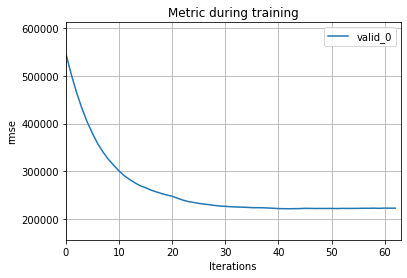

In [39]:
# plotando o gráfico de RMSE vs iterações
lgb.plot_metric(model, 'rmse')

In [40]:
# avaliando o desempenho do modelo base-line
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
print('RMSE do modelo inicial (base-line):',rmse)
print('MAE do modelo inicial (base-line):',mae)

RMSE do modelo inicial (base-line): 221157.68711096622
MAE do modelo inicial (base-line): 130070.25759310885


In [41]:
# plotar gráfico de real vs predito do modelo base-line
df_plot = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})
df_plot['resid'] = df_plot['y_pred']-df_plot['y_test']
processador.plot_dataframe(df_plot,
                           x_column='y_test',
                           y_column='y_pred', 
                           chart_type='scatter', 
                           title='Real vs Predito no modelo de base-line', 
                           y_label='Valores Preditos',
                           x_label='Valores Reais')

In [42]:
# plotando a variação na distribuição dos erros
df_plot['residuos'] = y_pred-y_test
processador.plot_dataframe(df_plot,
                           x_column='y_pred',
                           y_column='residuos', 
                           chart_type='scatter', 
                           title='Variação na distribuição dos erros do modelo de base-line', 
                           y_label='Resíduos/Erros',
                           x_label='Valores Preditos')

In [43]:
# Detecção de Heterocedasticidade para o modelo de base-line
exog_het = df_plot.drop(['resid','y_pred'], axis=1)

# Executar o teste de Breusch-Pagan
breusch_pagan_test = het_breuschpagan(df_plot['resid'], exog_het)[3]

# verificar se o valor-p é menor que 0,05
if breusch_pagan_test < 0.05:
    print("Heterocedasticidade detectada com p-valor =", breusch_pagan_test)
else:
    print("Não foi detectada heterocedasticidade com p-valor =", breusch_pagan_test)

Heterocedasticidade detectada com p-valor = 1.249054177612642e-209


---

### Agora os dados do modelo final

**(Como mencionado acima, os experimentos de criação e tunagem de modelos foram realizados no H2oCloud e a tabela de predição do teste foi exportado para o Kaggle)**

In [45]:
# Importando os dados de predição nos dados de teste do modelo final
preditos = processador.importar_dados('/kaggle/input/real-vs-predito/real_vs_predito.csv')
preditos = preditos.iloc[:,1:]
preditos.columns = ['Previsao', 'Residuos','Weekly_Sales']
dados_previsao = df_model.loc[df_model['Date'] > '2011-08-26']
dados_previsao = dados_previsao.merge(preditos, on='Weekly_Sales')
dataset_final = df_model.loc[df_model['Date'] <= '2011-08-26']
# vou add as 3 colunas do dataframe importado acima aos dados originais para plotagem dos resultados e avaliação do modelo
dataset_final = dataset_final.append(dados_previsao)
dataset_final = dataset_final.groupby('Date').agg('mean').reset_index()
dataset_final.rename(columns={'Weekly_Sales': 'Vendas Semanais'}, inplace=True)
#px.line(dataset_final, x='Date', y=['Weekly_Sales','Previsao'], range_y=[0,2000000])
processador.plot_dataframe(dataset_final,
                           x_column='Date',
                           y_column=['Vendas Semanais','Previsao'], 
                           chart_type='line',
                           range_y=[0,2000000],
                           title='Temperatura média nas semanas', 
                           width=1120, 
                           height=560,
                           x_label='Data',
                           y_label='Temperatura Cº')

In [46]:
# plotando a variação na distribuição dos erros do modelo final
processador.plot_dataframe(preditos,
                           x_column='Previsao',
                           y_column='Residuos', 
                           chart_type='scatter', 
                           title='Variação na distribuição dos erros do modelo final', 
                           y_label='Resíduos/Erros',
                           x_label='Valores Preditos')

In [47]:
# plotar gráfico de real vs predito do modelo final
processador.plot_dataframe(preditos,
                           x_column='Previsao',
                           y_column='Weekly_Sales', 
                           chart_type='scatter', 
                           title='Variação na distribuição dos erros do modelo final', 
                           y_label='Valores Reais das vendas $',
                           x_label='Valores Preditos pelo modelo final')

---
### Métricas de Avaliação e Inspeção dos erros do modelo final


In [48]:
y_predito = preditos['Previsao']
erro = preditos['Residuos']
y_teste = preditos['Weekly_Sales']

# Calcula o RMSE
rmse = np.sqrt(mean_squared_error(y_predito, y_teste))
print('RMSE do modelo Final: ', round(rmse,2))
# Calcula o MAE
mae = mean_absolute_error(y_predito, y_teste)
print('MAE do modelo Final: ', round(mae,2))

RMSE do modelo Final:  82861.4
MAE do modelo Final:  53410.1


In [49]:
# Teste de Breusch-Pagan
from statsmodels.stats.diagnostic import het_breuschpagan
exog_het = preditos.drop(['Residuos','Previsao'], axis=1)

# Executar o teste de Breusch-Pagan
breusch_pagan_test = het_breuschpagan(preditos['Residuos'], exog_het)[3]

# verificar se o valor-p é menor que 0,05
if breusch_pagan_test < 0.05:
    print("Heterocedasticidade detectada com p-valor =", breusch_pagan_test)
else:
    print("Não foi detectada heterocedasticidade com p-valor =", breusch_pagan_test)

Heterocedasticidade detectada com p-valor = 2.1052802507530886e-44


In [50]:
# O teste de Shapiro-Wilk testa a hipótese nula de que uma amostra veio de uma população normalmente distribuída. 
processador.plot_dataframe(preditos['Residuos'],
                           chart_type='histogram', 
                           title='Teste de normalidade nos dados do modelo final', 
                           x_label='Distribuição dos erros do modelo final',
                           y_label='Frequência dos valores',
                           showlegend=False)


stats_teste, p_valor_teste = stats.shapiro(preditos['Residuos'])
signific = 0.05

if p_valor_teste < signific:
    print(f'p valor: {round(p_valor_teste,6)} Rejeitar H0!!! NÃO há evidências de que os dados testados são normalmente distribuídos.')
else:
    print(f'p valor: {round(p_valor_teste,6)} H0 não pode ser rejeitada, pois HÁ evidências de que os dados testados são normalmente distribuídos.')

p valor: 0.0 Rejeitar H0!!! NÃO há evidências de que os dados testados são normalmente distribuídos.


---

### **Imagens de como ficou o dashboard de apresentação de resultados na etapa 3/3**

![](https://imgur.com/hoSsGtd.png)

![](https://imgur.com/3vbF6G7.png)

![](https://imgur.com/1K4QwMs.png)

---
### Existem várias maneiras de diminuir a heterocedasticidade.

**Algumas dessas maneiras incluem:**

1- Remover variáveis irrelevantes ou correlacionadas. Isso pode ajudar a diminuir a variabilidade nas previsões e, consequentemente, a heterocedasticidade.

2 - Transformar as variáveis dependentes ou independentes. Isso pode ajudar a tornar a relação entre as variáveis mais linear e menos variavel.

3 - Usar regularização no modelo de regressão. Isso pode ajudar a restringir a flexibilidade do modelo e, consequentemente, diminuir a variabilidade das previsões.

4 - Usar métodos de redução de dimensionalidade, como principal component analysis (PCA), para identificar e remover as principais fontes de variabilidade no modelo.

5 - Usar métodos de otimização de hiperparâmetros para encontrar os melhores valores dos hiperparâmetros do modelo. Isso pode ajudar a reduzir a variabilidade das previsões e, consequentemente, a heterocedasticidade.

---

### Obserações Importantes

As informações abaixo, entre outras, estão disponíveis em mais detalhes no relatório do modelo desenvolvido no link:
https://docs.google.com/document/d/1txU8MsedtUzcEBwzbiWXXru-2EF1CcGz/edit?usp=sharing&ouid=100792851349155706678&rtpof=true&sd=true


**Métricas do modelo Final**


|Métrica|Pontuações no Treinamento|Desvio Padrão no Treinamento|RMSE do Teste|Desvio Padrão do Teste|
|:----------|----------|----------|----------|----------|
|RMSE   |140.832 |5.328.68 |81.820.72 |5.328.68 |
|MAE |74984.23 |1925.66 |52683.84 |1925.66 |


---

**Metodologia**

Experimento do Pipeline
Para este experimento, a DriverlessAI realizou as seguintes etapas para encontrar o modelo final ideal:

Os passos são descritos abaixo:

Este estágio combina o ajuste aleatório de hiperparâmetros com seleção e geração de recursos. Os recursos em cada iteração são atualizados usando a importância variável da iteração anterior como probabilística antes de decidir quais novos recursos criar. O modelo e os recursos com melhor desempenho são então passados para o estágio de evolução do recurso.

⦁ No experimento de automl, encontrou-se os parâmetros ideais para modelos constant, xgboost e lightgbm treinando modelos com diferentes parâmetros

⦁ Os melhores parâmetros são aqueles que geram o menor RMSE nos dados de validação interna

⦁ 41 modelos treinados e pontuados para avaliar recursos e parâmetros do modelo

---
**Feature Evolution**

Esta etapa usa um algoritmo genético para encontrar o melhor conjunto de parâmetros do modelo e transformações de recursos a serem usados no modelo final.

⦁ encontrou a melhor representação dos dados para o treinamento do modelo final, criando e avaliando 48 recursos em 33 iterações

⦁ 364 modelos treinados e pontuados para avaliar melhor os recursos de engenharia

---

**Modelo Final**

⦁ Foi criado o melhor modelo das iterações de engenharia de recursos

⦁ Nenhum conjunto ensemble é feito porque uma coluna Date (de tempo) foi fornecida

---

**Etapas de Criação e Otimização dos modelos**

|Etapa|Tempo (minutos)|Número de Modelos|
|:----------|----------|----------|
|Modela e Tuna as Variáveis|4|41|
|Criação de Novas Variáveis|24|364|
|Treino do modelo Final|2|1|


---

**As seguintes transformadores foram realizadas nos dados:**

|Transformações|Descrição|
|----------|:----------|
|InteractionsTransformer:| Adiciona, Divide, Multiplica e Subtrai duas colunas numéricas nos dados para criar um novo recurso.|
|CatOriginalTransformer:| Aplica uma transformação de identidade que deixa os recursos categóricos como estão.|
|FrequentTransformer:| Calcula a frequência para cada valor nas colunas categóricas e usa isso como um novo recurso.|
|CatTransformer:| Classifica uma coluna categórica em ordem lexicográfica e usa o índice de ordem criado como um novo recurso.|
|OneHotEncodingTransformer:| Converte uma coluna categórica em uma série de recursos booleanos executando a codificação one-hot. Os recursos booleanos são usados como novos recursos.|
|IsHolidayTransformer:| Determina se uma coluna de data é feriado. Uma coluna booleana indicando se a data é um feriado é adicionada como um novo recurso.|
|DatesTransformer:| Recupera quaisquer valores de data ou hora, incluindo: Ano, Trimestre, Mês, Dia, Dia do Ano, Semana, Dia da Semana, Hora, Minuto, Segundo.|
|EwmaLagsTransformer:| O transformador de média móvel ponderada exponencial (EWMA) calcula a média móvel ponderada exponencial dos atrasos da coluna que se fará a previsão (Vendas semanais).|


---
**Detecção de Vazamento nos Dados**

A IA do sistema H2o pode realizar a detecção de deslocamento entre os conjuntos de dados de treinamento, validação e teste. Ela faz isso treinando um modelo binomial para prever a qual conjunto de dados um registro pertence. Por exemplo, ser capaz de separar os dados de treinamento e teste com uma AUC de 0,8 usando apenas a coluna: C1 como preditor. Isso indica que há algum tipo de desvio na distribuição de C1 entre os dados de treinamento e teste.
Para este experimento, a AI verificou os dados do treino e do teste em busca de qualquer mudança nas distribuições, **mas não encontrou nenhuma. Isso indica que todos os preditores/colunas nos dados de treinamento e teste são da mesma distribuição.**

*Obs: Na verdade foi encontrado vazamento na coluna Size (que é o tamanho da loja, com base no faturamento daquela semana), ou seja, é um dado "do futuro" e por conta disso foi removida.*

---

**Link do relatório do modelo**

https://docs.google.com/document/d/1txU8MsedtUzcEBwzbiWXXru-2EF1CcGz/edit?usp=sharing&ouid=100792851349155706678&rtpof=true&sd=true

**Deseja entrar em contato comigo?**

Meu portifólio: https://portfolio.powerbiexperience.com/p/ueliton

---
### **Por hoje é só. Sugestões são bem vindas ;)**